<a href="https://colab.research.google.com/github/swilsonmfc/deeplearning/blob/master/LearningRates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Rates

![](https://pyimagesearch.com/wp-content/uploads/2019/08/keras_learning_rate_finder_header.png)

# Install

In [1]:
pip install keras-one-cycle-lr

# Setup

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.utils import to_categorical

import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Data

In [6]:
cifar10 = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [7]:
(X_train, y_train), (X_test, y_test) = cifar10

In [8]:
print(f'Training Images {X_train.shape}, Labels {y_train.shape}')
print(f'Testing  Images {X_test.shape}, Labels {y_test.shape}')

Training Images (50000, 32, 32, 3), Labels (50000, 1)
Testing  Images (10000, 32, 32, 3), Labels (10000, 1)


In [9]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

X_train /= 255
X_test  /= 255

In [10]:
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

In [11]:
class_names = [
    'car',
    'plane',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']

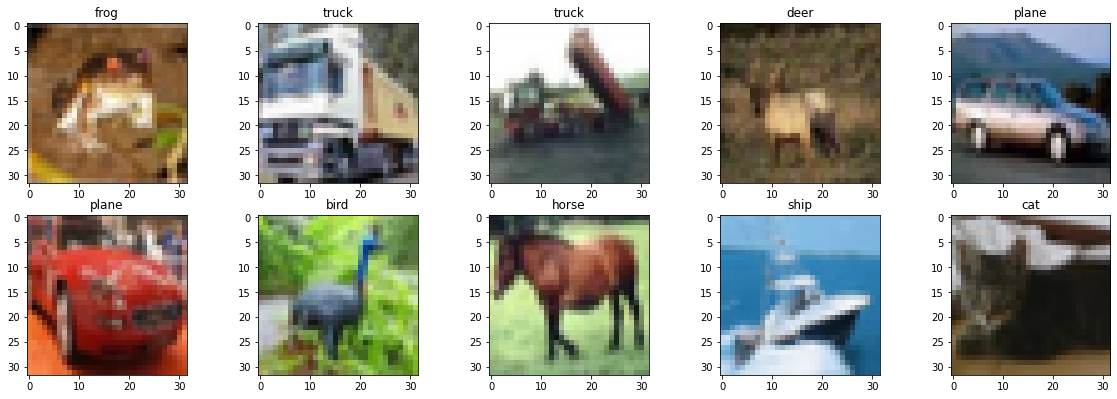

In [12]:
plt.figure(figsize=(20,10))
cols = 5
for i, image in enumerate(X_train[0:10, :]):
    plt.subplot(10 / cols + 1, cols, i + 1)
    plt.imshow(image.squeeze())
    plt.title(class_names[y_train[i].argmax()]);

# Learning Plots

In [13]:
def plot_performance(history, color='b'):
    fig, ax = plt.subplots(figsize=(12,10))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    ax = plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', color=color, label='Train')
    plt.plot(epochs, val_acc, 'b', color=color, label='Validation')
    plt.title('Training & Validation Accuracy')
    plt.ylabel('Accuracy')
    ax.legend()
    
    ax = plt.subplot(2, 1, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)    
    plt.plot(epochs, loss, 'bo', color=color, label='Train')
    plt.plot(epochs, val_loss, 'b', color=color, label='Validation')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [14]:
def compare_history(histories):
    colors = (c for c in ['blue', 'orange', 'green', 'black', 'red', 'purple'])
    fig, ax = plt.subplots(figsize=(12,10))
    
    ax = plt.subplot(2, 1, 1)
    for key, history in histories.items():
        val_acc = history.history['val_accuracy']
        epochs = range(1, len(val_acc) + 1)
        plt.plot(epochs, val_acc, 'b', label=key, color=next(colors))   
        plt.title('Validation Accuracy')
        plt.ylabel('Accuracy')
    ax.legend()
    
    plt.show();

In [15]:
def plot_confusion(test, pred):
    cm = confusion_matrix(test, pred)
    df = pd.DataFrame(cm, class_names, class_names)
    plt.figure(figsize=(10, 10))
    sns.heatmap(df, annot=True, fmt='d', cmap='BuGn')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

# Learning Rates
![](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

# Model

In [16]:
def create_model():
    input_shape = (32, 32, 3)
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(12, kernel_size=(5, 5), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

# Parameters

In [17]:
BATCH_SIZE = 64
EPOCHS = 20

# Baseline
* We'll use Adam (Adaptive Moment Estimation)
* Accept the default 0.001 learning rate

In [18]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten (Flatten)            (None, 1200)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               120100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
__________________________________________________

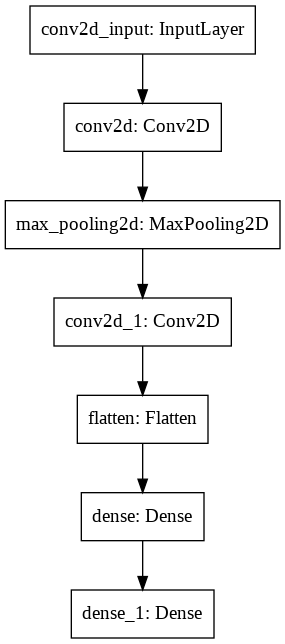

In [19]:
plot_model(model)

In [21]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [22]:
history_default = model.fit(X_train, y_train, 
                            batch_size=BATCH_SIZE, 
                            epochs=EPOCHS, 
                            validation_data=(X_test, y_test),
                            shuffle=True)

Epoch 1/20
782/782 [==============================] - 46s 57ms/step - loss: 1.6730 - accuracy: 0.3942 - val_loss: 1.4500 - val_accuracy: 0.4817
Epoch 2/20
782/782 [==============================] - 45s 58ms/step - loss: 1.3992 - accuracy: 0.4969 - val_loss: 1.4012 - val_accuracy: 0.5017
Epoch 3/20
782/782 [==============================] - 45s 58ms/step - loss: 1.2937 - accuracy: 0.5386 - val_loss: 1.2980 - val_accuracy: 0.5367
Epoch 4/20
782/782 [==============================] - 46s 58ms/step - loss: 1.2220 - accuracy: 0.5645 - val_loss: 1.2853 - val_accuracy: 0.5424
Epoch 5/20
782/782 [==============================] - 46s 58ms/step - loss: 1.1606 - accuracy: 0.5889 - val_loss: 1.2311 - val_accuracy: 0.5667
Epoch 6/20
782/782 [==============================] - 46s 59ms/step - loss: 1.1054 - accuracy: 0.6100 - val_loss: 1.2033 - val_accuracy: 0.5743
Epoch 7/20
782/782 [==============================] - 46s 59ms/step - loss: 1.0639 - accuracy: 0.6229 - val_loss: 1.2140 - val_accuracy:

In [23]:
proba = model.predict(X_test) 
pred  = proba.argmax(axis=-1)
print(model.evaluate(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


313/313 [==============================] - 4s 13ms/step - loss: 1.4490 - accuracy: 0.5721
[1.448979139328003, 0.5720999836921692]


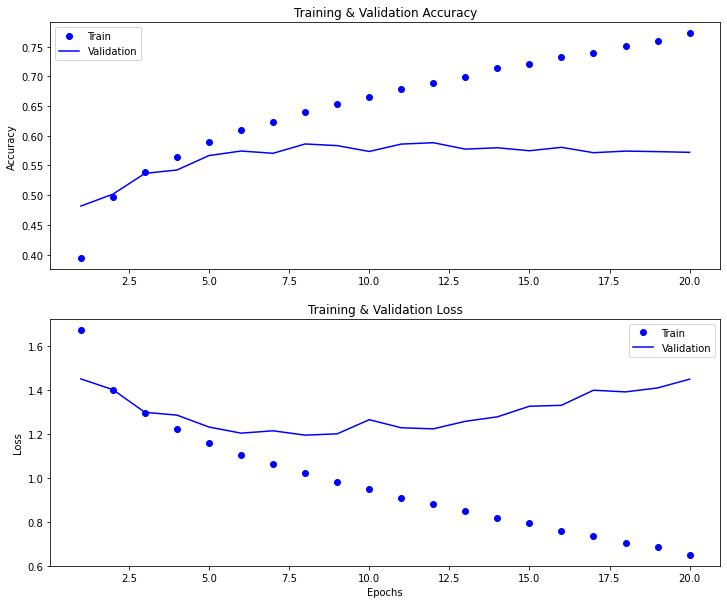

In [24]:
plot_performance(history_default)

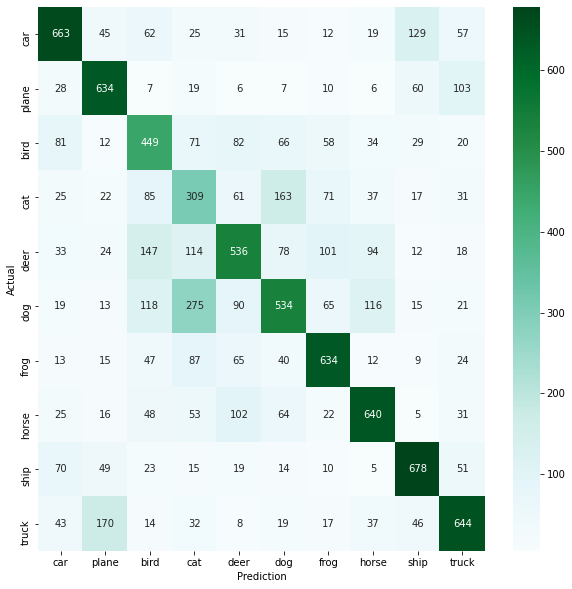

In [25]:
plot_confusion(pred, y_test.argmax(-1))

# Karpathy

![](https://pbs.twimg.com/media/DXdvgY_WAAYuPKn?format=jpg&name=900x900)

In [59]:
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten_5 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_11 (Dense)             (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
________________________________________________

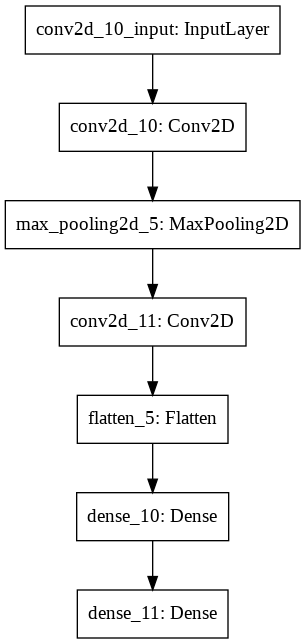

In [60]:
plot_model(model)

In [61]:
model.compile(optimizer=Adam(learning_rate=3e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [62]:
history_karpathy = model.fit(X_train, y_train, 
                            batch_size=BATCH_SIZE, 
                            epochs=EPOCHS, 
                            validation_data=(X_test, y_test),
                            shuffle=True)

Epoch 1/20
782/782 [==============================] - 45s 57ms/step - loss: 1.7487 - accuracy: 0.3726 - val_loss: 1.5825 - val_accuracy: 0.4306
Epoch 2/20
782/782 [==============================] - 45s 57ms/step - loss: 1.4893 - accuracy: 0.4686 - val_loss: 1.4800 - val_accuracy: 0.4826
Epoch 3/20
782/782 [==============================] - 45s 57ms/step - loss: 1.3948 - accuracy: 0.5081 - val_loss: 1.3868 - val_accuracy: 0.5083
Epoch 4/20
782/782 [==============================] - 45s 57ms/step - loss: 1.3330 - accuracy: 0.5302 - val_loss: 1.3395 - val_accuracy: 0.5229
Epoch 5/20
782/782 [==============================] - 45s 57ms/step - loss: 1.2854 - accuracy: 0.5463 - val_loss: 1.3305 - val_accuracy: 0.5228
Epoch 6/20
782/782 [==============================] - 45s 57ms/step - loss: 1.2471 - accuracy: 0.5605 - val_loss: 1.2897 - val_accuracy: 0.5440
Epoch 7/20
782/782 [==============================] - 45s 57ms/step - loss: 1.2202 - accuracy: 0.5718 - val_loss: 1.2453 - val_accuracy:

In [63]:
proba = model.predict(X_test) 
pred  = proba.argmax(axis=-1)
print(model.evaluate(X_test, y_test))

313/313 [==============================] - 4s 13ms/step - loss: 1.1434 - accuracy: 0.6010
[1.1434211730957031, 0.6010000109672546]


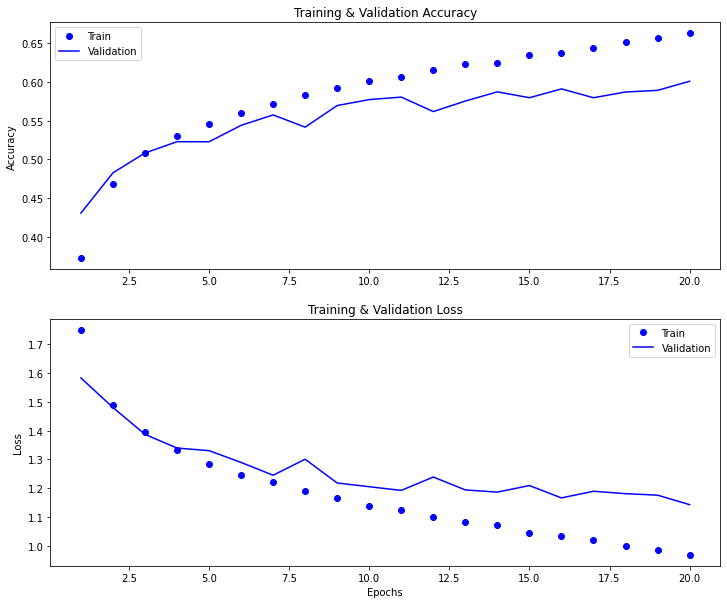

In [64]:
plot_performance(history_karpathy)

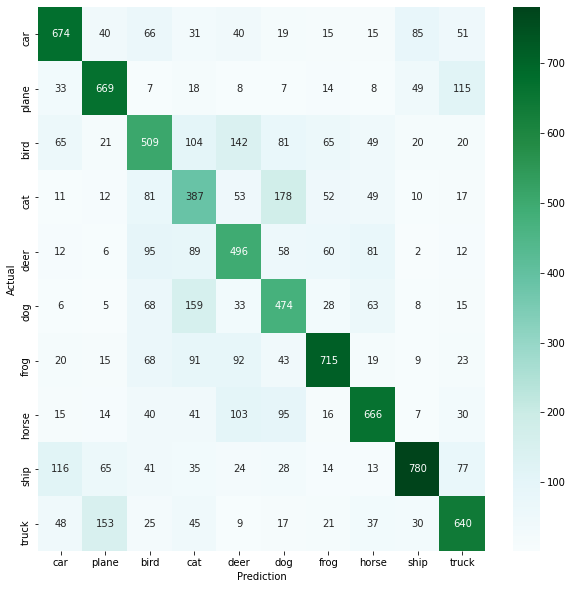

In [65]:
plot_confusion(pred, y_test.argmax(-1))

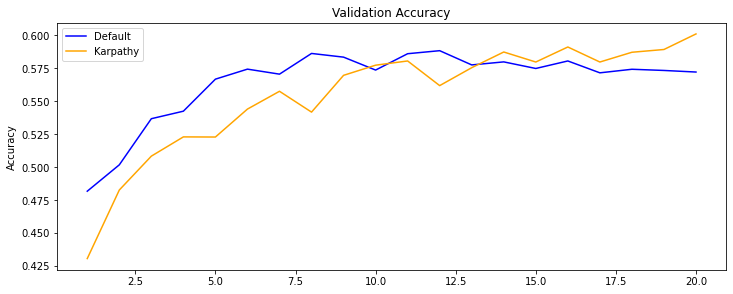

In [104]:
compare_history({'Default': history_default,
                 'Karpathy': history_karpathy})

# Auto Rate Finder
* Implemented by Pavel Surmenok
  * http://github.com/surmenok/keras_lr_finder
  * Adjusted for tensorflow 2.1
  * Adjusted graphing
  * Fix to get_best_lr
* A disciplined approach to neural network hyper-parameters (https://arxiv.org/abs/1803.09820)
  * Exponentially increase the learning rate by batch
  * Select a place where the learning rate is associated with the fastest decrease in loss
  * You'll often see something like the following plot
  * Where the best range is between 0.01 and 0.1

![](https://miro.medium.com/max/584/1*HVj_4LWemjvOWv-cQO9y9g.png)

In [ ]:
class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            print(' Stopping')
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.learning_rate, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.learning_rate)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.learning_rate, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.learning_rate, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log', marker=None):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.figure(figsize=(8,6))
        if marker is not None:
            plt.axvline(x=marker, color='red')
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01), marker=None):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.figure(figsize=(8,6))
        if marker is not None:
            plt.axvline(x=marker, color='red')
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmax(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

## Best Rate

In [75]:
model = create_model()

In [76]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [77]:
lr_finder = LRFinder(model)    
lr_finder.find(X_train, y_train, start_lr=1e-6, end_lr=0.5, batch_size=512, epochs=5)

Epoch 1/5
98/98 [==============================] - 33s 332ms/step - loss: 2.3261 - accuracy: 0.1044
Epoch 2/5
98/98 [==============================] - 32s 328ms/step - loss: 2.2346 - accuracy: 0.1856
Epoch 3/5
98/98 [==============================] - 33s 337ms/step - loss: 1.7858 - accuracy: 0.3673
Epoch 4/5
98/98 [==============================] - 33s 338ms/step - loss: 1.8997 - accuracy: 0.3256
Epoch 5/5
98/98 [==============================] - 33s 336ms/step - loss: 2.1146 - accuracy: 0.2195


In [112]:
best = lr_finder.get_best_lr(sma=20, n_skip_beginning=50, n_skip_end=50)
best

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.00024919509887695314, -0.00016031265258789062, -0.0005226016044616699, -0.0005741596221923828, -0.00037440061569213865, -0.0002457261085510254, -7.870197296142579e-05, -9.832382202148437e-05, -5.1140785217285156e-05, -7.431507110595703e-05, -7.544755935668945e-05, 7.181167602539062e-05, 3.5047531127929686e-06, -6.532669067382812e-06, 2.9027462005615234e-05, -6.4730644226074215e-06, -2.3245811462402344e-06, -5.142688751220703e-05, -2.4306774139404298e-05, -0.0001261115074157715, -7.846355438232422e-05, -8.481740951538086e-05, -5.409717559814453e-05, -7.466077804565429e-05, -3.97801399230957e-05, -2.5820732116699218e-05, -7.700920104980468e-06, -3.802776336669922e-05, -5.941390991210937e-05, -5.605220794677734e-05, -8.734464645385743e-05, -9.28044319152832e-05, -6.948709487915039e-05, -7.165670394897461e-05, -5.129575729370117e-05, -3.4928321838378906e-05, -4.419088363647461e-05, -4.279613494873047e-05, -3.4928321838378906e-0

0.0046221893

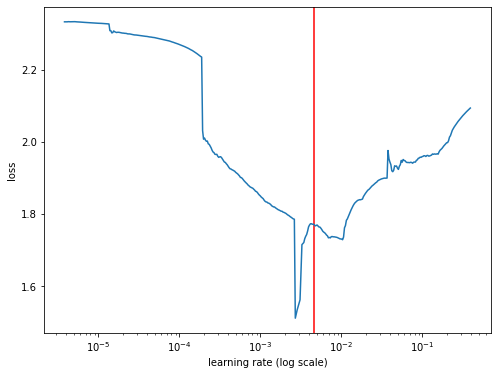

In [113]:
lr_finder.plot_loss(n_skip_beginning=50, n_skip_end=10, marker=best)

## Model

In [81]:
model = create_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten_7 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
________________________________________________

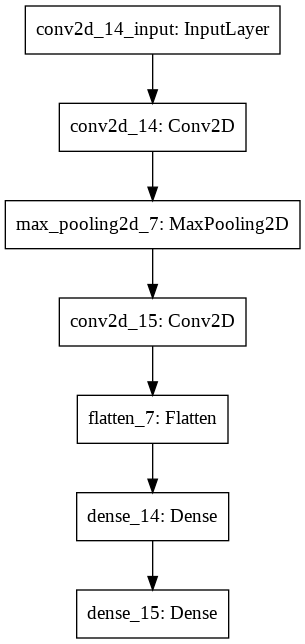

In [82]:
plot_model(model)

In [83]:
model.compile(optimizer=Adam(learning_rate=best), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [84]:
history_best = model.fit(X_train, y_train, 
                            batch_size=BATCH_SIZE, 
                            epochs=EPOCHS, 
                            validation_data=(X_test, y_test),
                            shuffle=True)

Epoch 1/20
782/782 [==============================] - 45s 57ms/step - loss: 1.7225 - accuracy: 0.3662 - val_loss: 1.6498 - val_accuracy: 0.3958
Epoch 2/20
782/782 [==============================] - 44s 56ms/step - loss: 1.5032 - accuracy: 0.4551 - val_loss: 1.5403 - val_accuracy: 0.4469
Epoch 3/20
782/782 [==============================] - 44s 56ms/step - loss: 1.4300 - accuracy: 0.4883 - val_loss: 1.4719 - val_accuracy: 0.4700
Epoch 4/20
782/782 [==============================] - 44s 57ms/step - loss: 1.3822 - accuracy: 0.5054 - val_loss: 1.4906 - val_accuracy: 0.4788
Epoch 5/20
782/782 [==============================] - 44s 57ms/step - loss: 1.3297 - accuracy: 0.5249 - val_loss: 1.4259 - val_accuracy: 0.4973
Epoch 6/20
782/782 [==============================] - 45s 57ms/step - loss: 1.2893 - accuracy: 0.5394 - val_loss: 1.4916 - val_accuracy: 0.4704
Epoch 7/20
782/782 [==============================] - 45s 57ms/step - loss: 1.2639 - accuracy: 0.5455 - val_loss: 1.4327 - val_accuracy:

In [85]:
proba = model.predict(X_test) 
pred  = proba.argmax(axis=-1)
print(model.evaluate(X_test, y_test))

313/313 [==============================] - 4s 13ms/step - loss: 1.9587 - accuracy: 0.4625
[1.9586933851242065, 0.4625000059604645]


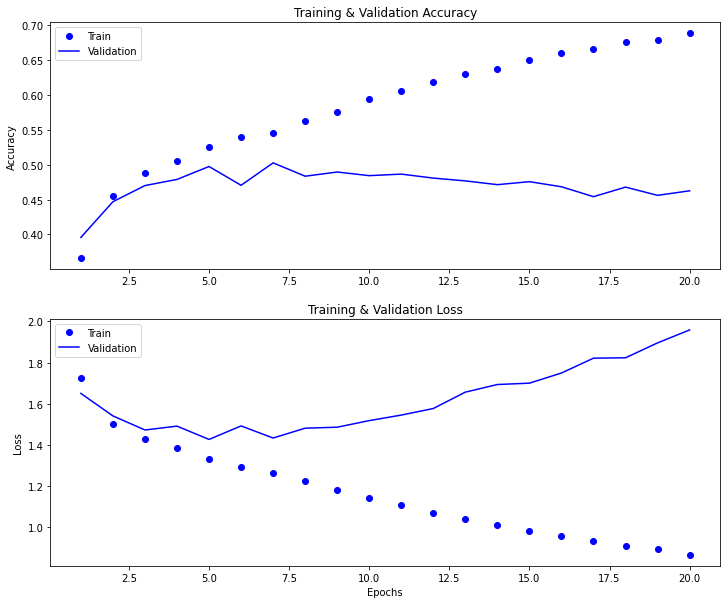

In [86]:
plot_performance(history_best)

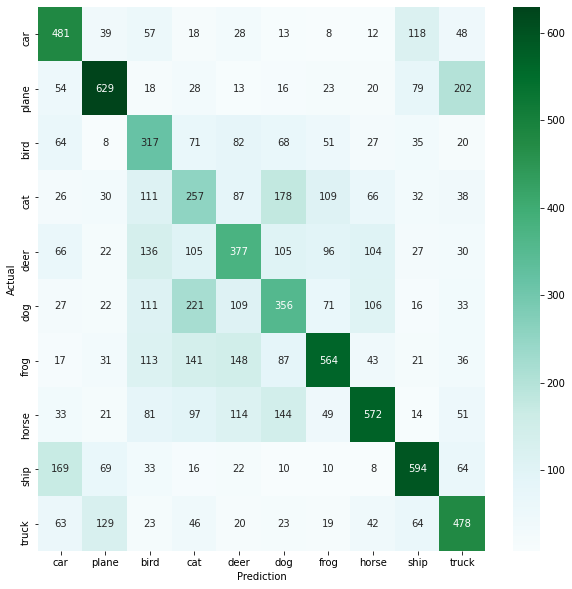

In [87]:
plot_confusion(pred, y_test.argmax(-1))

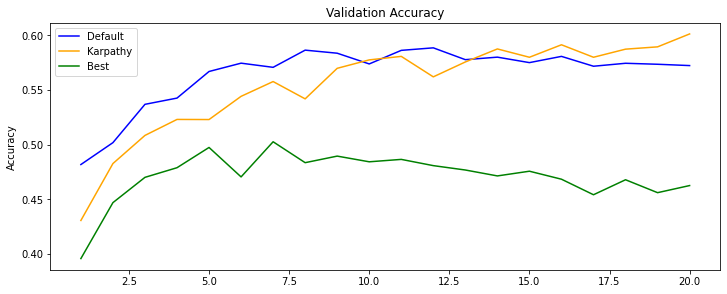

In [116]:
compare_history({'Default': history_default, 
                 'Karpathy': history_karpathy, 
                 'Best': history_best})

# Manual Rate Finder
* Try and find a better value
* Look on plot, rate of change vs learning rate
* Place near a minimum

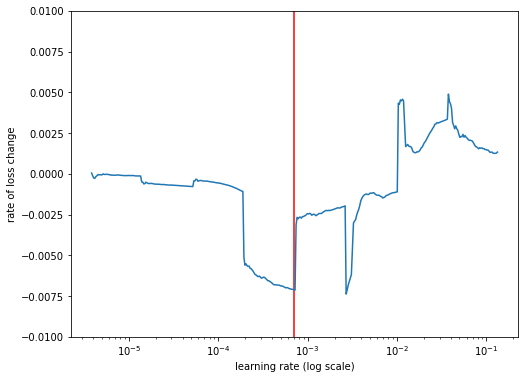

In [96]:
lr_finder.plot_loss_change(sma=50, n_skip_beginning=50, n_skip_end=50, marker=7e-4)

In [97]:
model = create_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten_8 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 100)               120100    
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
________________________________________________

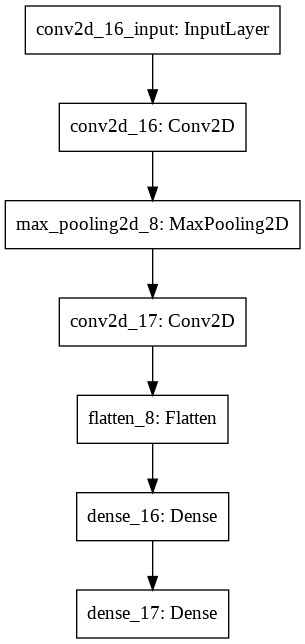

In [98]:
plot_model(model)

In [99]:
model.compile(optimizer=Adam(learning_rate=3e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [100]:
history_manual = model.fit(X_train, y_train, 
                            batch_size=BATCH_SIZE, 
                            epochs=EPOCHS, 
                            validation_data=(X_test, y_test),
                            shuffle=True)

Epoch 1/20
782/782 [==============================] - 45s 57ms/step - loss: 1.7184 - accuracy: 0.3826 - val_loss: 1.4962 - val_accuracy: 0.4648
Epoch 2/20
782/782 [==============================] - 45s 57ms/step - loss: 1.4406 - accuracy: 0.4846 - val_loss: 1.3949 - val_accuracy: 0.5066
Epoch 3/20
782/782 [==============================] - 45s 57ms/step - loss: 1.3600 - accuracy: 0.5195 - val_loss: 1.3675 - val_accuracy: 0.5146
Epoch 4/20
782/782 [==============================] - 45s 58ms/step - loss: 1.3073 - accuracy: 0.5398 - val_loss: 1.3014 - val_accuracy: 0.5354
Epoch 5/20
782/782 [==============================] - 45s 58ms/step - loss: 1.2668 - accuracy: 0.5537 - val_loss: 1.2603 - val_accuracy: 0.5573
Epoch 6/20
782/782 [==============================] - 45s 58ms/step - loss: 1.2326 - accuracy: 0.5670 - val_loss: 1.2636 - val_accuracy: 0.5567
Epoch 7/20
782/782 [==============================] - 45s 58ms/step - loss: 1.2034 - accuracy: 0.5779 - val_loss: 1.2361 - val_accuracy:

In [101]:
proba = model.predict(X_test) 
pred  = proba.argmax(axis=-1)
print(model.evaluate(X_test, y_test))

313/313 [==============================] - 4s 13ms/step - loss: 1.1714 - accuracy: 0.5971
[1.1714197397232056, 0.597100019454956]


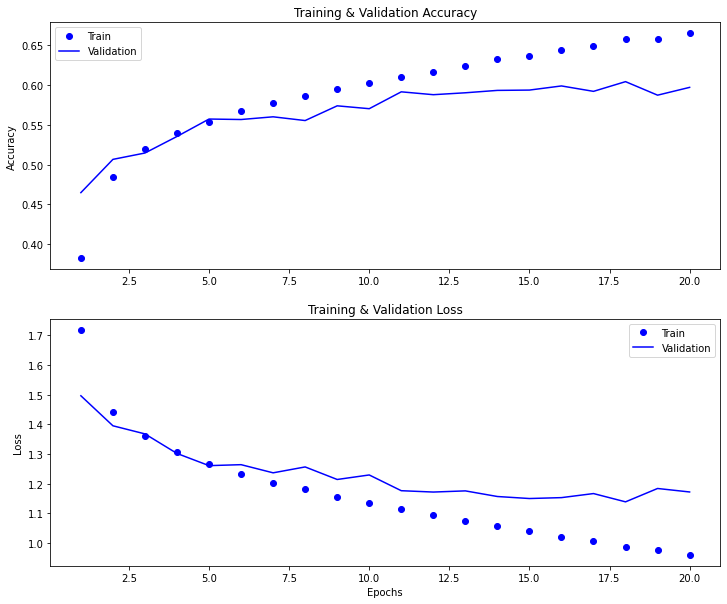

In [102]:
plot_performance(history_manual)

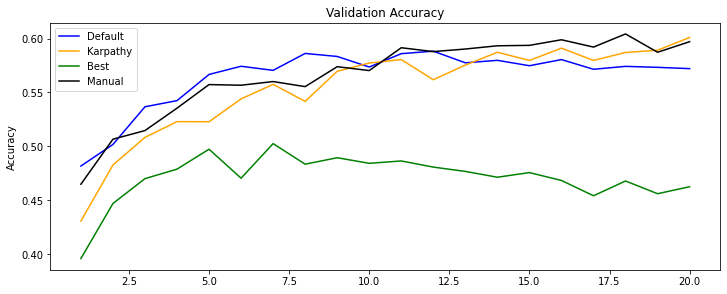

In [108]:
compare_history({'Default': history_default,
                 'Karpathy': history_karpathy,
                 'Best': history_best,
                 'Manual': history_manual})

# Scheduler
* Intuition
  * We should take large steps when we begin training
  * Randomly initiatlized weights are far from optimal
  * We should take smaller steps as we get closer to the minimum
* Keras has several implementations
  * Exponential Decay
  * Inverse Time Decay
  * Piecewise Constant Decay
  * Polynomial Decay

In [26]:
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               120100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
________________________________________________

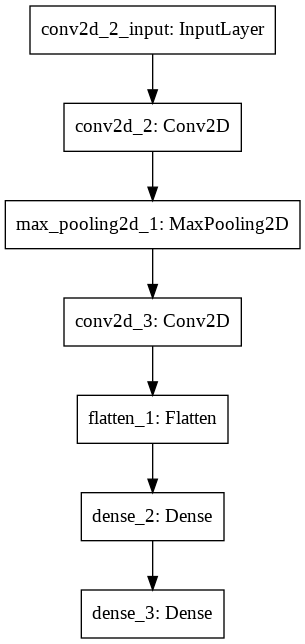

In [27]:
plot_model(model)

In [28]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [29]:
learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-3 if epoch < 10 else 1e-4, verbose=1)

history_schedule = model.fit(X_train, y_train, 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, 
                      validation_data=(X_test, y_test),
                      shuffle=True,
                      callbacks=[learning_rate_schedule])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
782/782 [==============================] - 46s 58ms/step - loss: 1.6348 - accuracy: 0.4107 - val_loss: 1.4277 - val_accuracy: 0.4870
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
782/782 [==============================] - 45s 58ms/step - loss: 1.3971 - accuracy: 0.4999 - val_loss: 1.3470 - val_accuracy: 0.5205
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
782/782 [==============================] - 46s 58ms/step - loss: 1.3173 - accuracy: 0.5290 - val_loss: 1.3727 - val_accuracy: 0.5122
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
782/782 [==============================] - 46s 59ms/step - loss: 1.2454 - accuracy: 0.5583 - val_loss: 1.2530 - val_accuracy: 0.5546
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
782/782 [==============================] - 46s 58ms/step - loss: 1.1

In [35]:
proba = model.predict(X_test) 
pred  = proba.argmax(axis=-1)
print(model.evaluate(X_test, y_test))

313/313 [==============================] - 4s 13ms/step - loss: 1.1198 - accuracy: 0.6134
[1.1197686195373535, 0.6133999824523926]


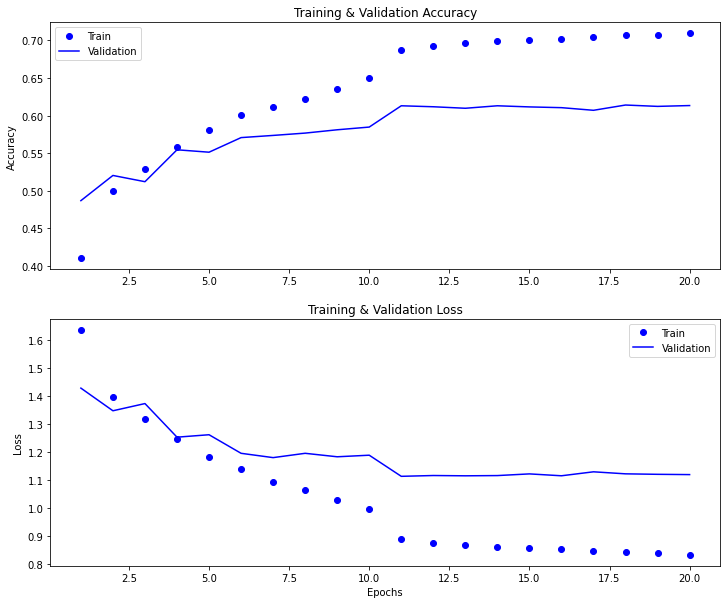

In [31]:
plot_performance(history_schedule)

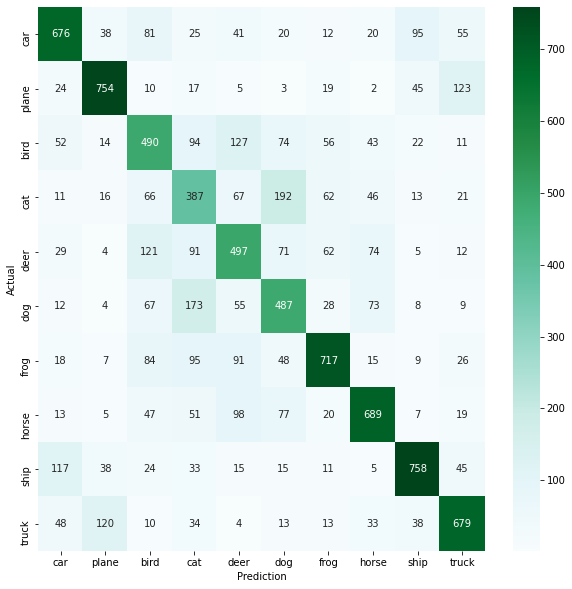

In [32]:
plot_confusion(pred, y_test.argmax(-1))

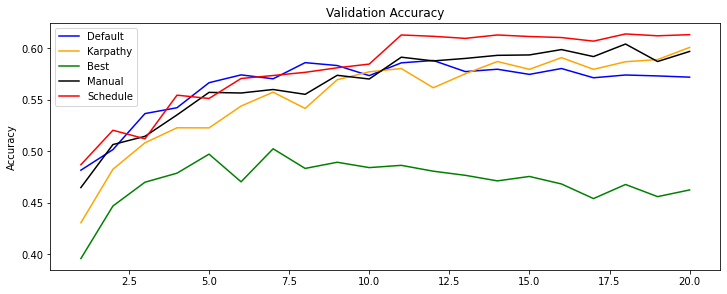

In [105]:
compare_history({'Default': history_default, 
                 'Karpathy': history_karpathy,
                 'Best': history_best,
                 'Manual': history_manual,
                 'Schedule': history_schedule})

# Plateau
* With Plateau we train util progress stops
* We then reduce our learning rate and continue

In [36]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 12)        1812      
_________________________________________________________________
flatten_2 (Flatten)          (None, 1200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               120100    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 123,378
Trainable params: 123,378
Non-trainable params: 0
________________________________________________

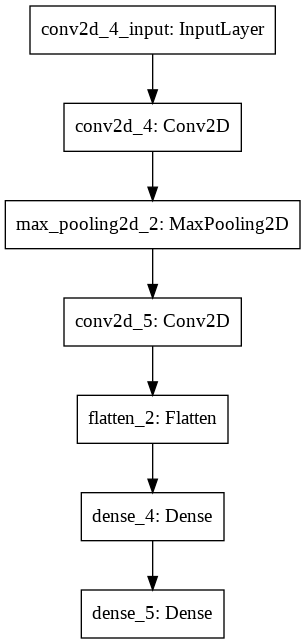

In [37]:
plot_model(model)

In [38]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [39]:
reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.5, 
                                         patience=2, 
                                         verbose=1)

history_plateau = model.fit(X_train, y_train, 
                      batch_size=BATCH_SIZE, 
                      epochs=EPOCHS, 
                      validation_data=(X_test, y_test),
                      shuffle=True,
                      callbacks=[reduce_learning_rate])

Epoch 1/20
782/782 [==============================] - 45s 58ms/step - loss: 1.6566 - accuracy: 0.4051 - val_loss: 1.5015 - val_accuracy: 0.4585
Epoch 2/20
782/782 [==============================] - 45s 57ms/step - loss: 1.3845 - accuracy: 0.5042 - val_loss: 1.3518 - val_accuracy: 0.5107
Epoch 3/20
782/782 [==============================] - 45s 58ms/step - loss: 1.2762 - accuracy: 0.5457 - val_loss: 1.2562 - val_accuracy: 0.5482
Epoch 4/20
782/782 [==============================] - 45s 58ms/step - loss: 1.2152 - accuracy: 0.5709 - val_loss: 1.2728 - val_accuracy: 0.5440
Epoch 5/20
782/782 [==============================] - 45s 58ms/step - loss: 1.1617 - accuracy: 0.5866 - val_loss: 1.1931 - val_accuracy: 0.5724
Epoch 6/20
782/782 [==============================] - 46s 58ms/step - loss: 1.1171 - accuracy: 0.6080 - val_loss: 1.2167 - val_accuracy: 0.5730
Epoch 7/20
782/782 [==============================] - 46s 58ms/step - loss: 1.0838 - accuracy: 0.6170 - val_loss: 1.1593 - val_accuracy:

In [40]:
proba = model.predict(X_test) 
pred  = proba.argmax(axis=-1)
print(model.evaluate(X_test, y_test))

313/313 [==============================] - 4s 13ms/step - loss: 1.1493 - accuracy: 0.6143
[1.1493430137634277, 0.614300012588501]


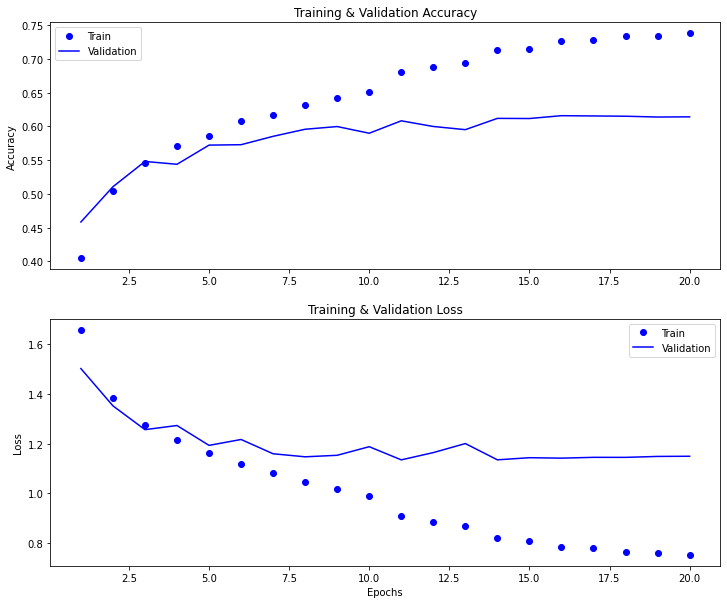

In [41]:
plot_performance(history_plateau)

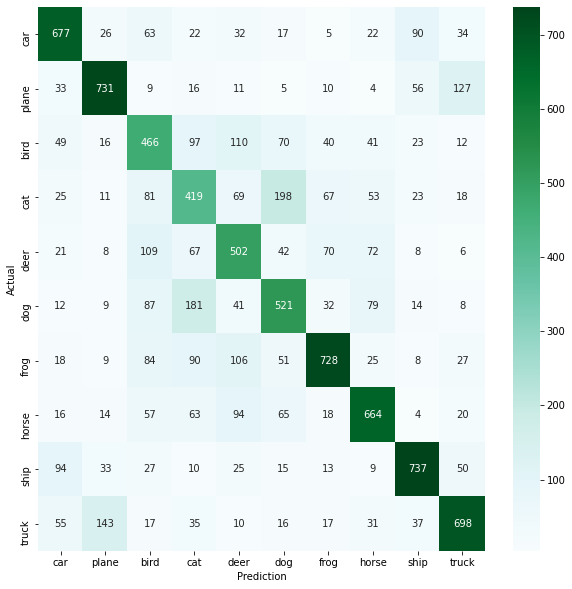

In [42]:
plot_confusion(pred, y_test.argmax(-1))

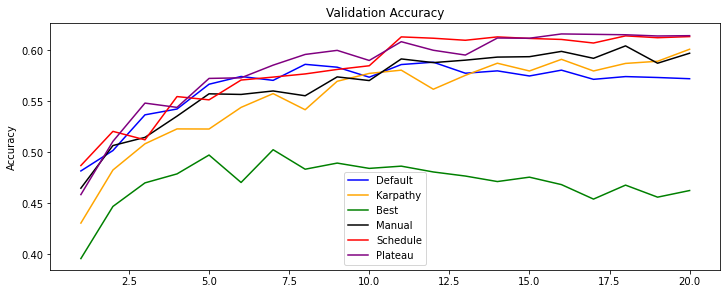

In [106]:
compare_history({'Default': history_default, 
                 'Karpathy': history_karpathy,
                 'Best': history_best,
                 'Manual': history_manual,
                 'Schedule': history_schedule,
                 'Plateau': history_plateau})

# Cyclical Learning
* Super-Convergence (https://arxiv.org/abs/1708.07120)
* Specify min / max learning rate and momentum
* First half of training
  * Increase learning rate
  * Decrease momentum
  * Why - Increasing learning rate - we can make large improvements early on with larger rate
  * Why - Momentum works against the large leraning rate
* Second half of training
  * Decrease learning rate
  * Increase momentum
  * Why - Having moved close, we're interested in taking smaller steps towards the minimum
  * Why - Momentum helps us as we take small steps (saddle points)
* Applied over one epoch
* Need to find a good learning rate min / min
* Implemented in FastAI & PyTorch as callbacks

![](https://i.imgur.com/cs84ifb.png)

# Insights
* Learning Rates
  * Too high - you step over the minimum and fail to learn
  * Too small - it takes many epochs (time and resources) to learn
* Good Learning Rate
  * Heuristic 
    * Start high (.1 or 0.01) and drop learning rate by magnitude
    * Grid search (if not expensive)
  * Rate Finder
    * Learning Rate finder to get good initial value
    * Drop on Plateau / Schedule to go further
  * Watch Learning Rate
    * Training slowly increase magnitude
    * Not learning decrease magnitude
    * Add in scheduling to learn quickly and apporach minimum
* Improvements
  * Rate schedules - finicky to pick a good schedule
  * Rate plateau - improvement, take smaller steps if you stop learning
  * One Cycle Learning
* Higher Accuracy on CIFAR
  * We have 60,000 Images (We could do augmentation to improve)
  * Increase network capacity (more layers, more filters)
    * In this example, we have a Conv2D 5x5 -> MaxPool -> Conv2D 5x5 *
    * We should achieve 75-80% with 4-5 Blocks of Conv2D 3x3 -> MaxPool (32 - 64 Filters)
  * Leverage a pre-trained network